# Cognition & Computation - Lab 2 ----- CHANGED TO USE EMNIST BALANCED

In [2]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [3]:
%%capture
get_dbn_library()

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv

from DBN import DBN

In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('data/','balanced', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/", 'balanced',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

nclasses = 47

In [7]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0002,
                xavier_init=False,
                increase_to_cd_k=False,
                # use_gpu=False)
                use_gpu=True)

In [8]:
num_epochs = 40
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2703   |0.0386   |308.1731 |6.3662   |
|20    |1.2106   |0.0353   |290.2565 |5.9859   |
|30    |1.1918   |0.0353   |284.0421 |5.6013   |
|40    |1.1845   |0.0342   |281.8998 |5.3059   |


## Linear readouts

In [9]:
def _move_parameters_to_cpu(dbn_emnist):
  for layer in dbn_emnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [10]:
_move_parameters_to_cpu(dbn_emnist)

Let's first compute the hidden representations:

In [11]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [12]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_train.data, 0)

In [13]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, nclasses)

  def forward(self, x):
    return self.linear(x)

### First hidden layer representations

Let's train the readout layer:

In [14]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_train.targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [15]:
rbm_layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 3.878286
epoch 100/1500, loss = 2.874106
epoch 200/1500, loss = 2.320529
epoch 300/1500, loss = 2.001490
epoch 400/1500, loss = 1.804404
epoch 500/1500, loss = 1.672775
epoch 600/1500, loss = 1.578583
epoch 700/1500, loss = 1.507327
epoch 800/1500, loss = 1.451038
epoch 900/1500, loss = 1.405053
epoch 1000/1500, loss = 1.366486
epoch 1100/1500, loss = 1.333461
epoch 1200/1500, loss = 1.304704
epoch 1300/1500, loss = 1.279318
epoch 1400/1500, loss = 1.256654


Let's test it on the hold-out dataset:

In [16]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_test.data, 0)

In [17]:
predictions_first_hidden = perceptron_first_hidden(hidden_repr_layer_1_test)

In [18]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [19]:
_compute_accuracy(predictions_first_hidden, emnist_test.targets)

0.6690425276756287

## Comparison with a feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [20]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, nclasses)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [21]:
ffnn = Feedforward(500)

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [22]:
temp = emnist_train.data.size()[0]
_train(ffnn, emnist_train.data.reshape((temp, 784)), epochs=120)

epoch 0/120, loss = 3.854245
epoch 10/120, loss = 3.820453
epoch 20/120, loss = 3.786776
epoch 30/120, loss = 3.751488
epoch 40/120, loss = 3.713459
epoch 50/120, loss = 3.671875
epoch 60/120, loss = 3.626162
epoch 70/120, loss = 3.575943
epoch 80/120, loss = 3.520988
epoch 90/120, loss = 3.461192
epoch 100/120, loss = 3.396581
epoch 110/120, loss = 3.327369


In [27]:
predictions_ffnn = ffnn(emnist_test.data.reshape((round(temp/6), 784)))

In [28]:
_compute_accuracy(predictions_ffnn, emnist_test.targets)

0.3959042429924011

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [29]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

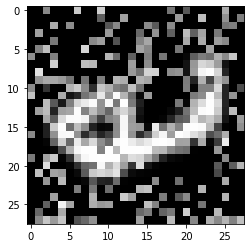

In [30]:
noise_level = 0.3
emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [36]:
temp2 = round(temp/6)
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0)  # here we compute the representations
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)  # here we use the readout layer
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((temp2, 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)
  return accuracy_first_hidden, accuracy_ffnn

In [37]:
_get_accuracy_values_at_noise_level(0.2)

(0.4867021143436432, 0.32654255628585815)

Let's now get an overview of the robustness of the representations to different levels of noise:

In [38]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

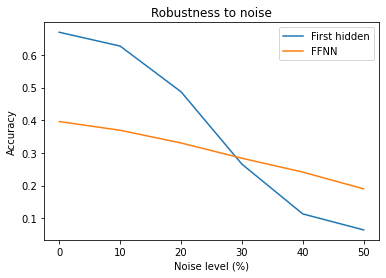

In [39]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)